In [104]:
import sys
sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import griddata
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from noaa.ghcnd import NOAAStore
from extremevalue.gpd import GPDMLE
from utils.geodata import usa_grid

## Load data from cache

In [3]:
store = NOAAStore()
stations = store.stations()

In [4]:
prcp = store.timeseries_universe(element='PRCP')

In [5]:
def coverage(s):
    start = s.index.get_level_values('date').min()
    end = s.index.get_level_values('date').max()
    count = s.count()
    length = (end-start).days+1
    coverage = count/length
    return {'start':start,'end':end,'coverage':coverage}
    

In [6]:
prcp_stats = pd.DataFrame(prcp.groupby('id').apply(coverage)).unstack(1)['value'].sort_values('coverage')
prcp_stats

,start,end,coverage
id,,,
USC00270390,1903-09-01,2022-04-30,0.043699
USC00478515,1936-11-01,2022-10-25,0.049769
USC00486875,1948-08-01,2022-10-31,0.05826
USC00042084,1914-01-01,2022-06-04,0.062497
USC00476854,1948-08-01,2022-11-30,0.066041
...,...,...,...
USW00024127,1948-01-01,2022-12-18,0.99989
USW00003822,1948-01-01,2022-12-18,0.99989
USW00023047,1947-01-01,2022-12-18,0.999892


## Compute statistics
* Coverage
* Return levels + standard errors
* Mean 

In [7]:
def returnlevel_stats(ts):
    start = ts.index.get_level_values('date').min()
    end = ts.index.get_level_values('date').max()
    count = ts.count()
    length = (end-start).days+1
    coverage = count/length
    
    rl = {
        '10y'     : np.nan,
        '10y_se'  : np.nan,
        '100y'    : np.nan,
        '100y_se' : np.nan,
        'xi'      : np.nan,
        'sigma'   : np.nan,
        'mean'    : np.nan,
        'mean_se' : np.nan,
    }
    
    if (count < 10000) | (coverage < 0.85):
        return rl
    
    
    u = ts.quantile(0.99)
    gpd = GPDMLE(u)
    gpd.fit(ts.values)

    period_1y = 365.25

    params = gpd.get_params()

    rl['10y'] =  gpd.return_level(10.0, period=period_1y)
    rl['10y_se'] =  gpd.return_level_se(10.0, period=period_1y)
    rl['100y'] =  gpd.return_level(100.0, period=period_1y)
    rl['100y_se'] =  gpd.return_level_se(100.0, period=period_1y)
    rl['xi'] = params['xi']
    rl['sigma'] = params['sigma']
    rl['mu'] = u
    rl['mean'] = ts.mean()
    rl['mean_se'] = ts.std()/np.sqrt(len(ts))

    return rl

In [8]:
prcp_filtered = prcp.loc[lambda x: (x>=0.0) & (x<1500.0)].copy() #simple cleaning for now
prcp_rl = prcp_filtered.groupby('id').apply(returnlevel_stats).unstack(1).dropna()

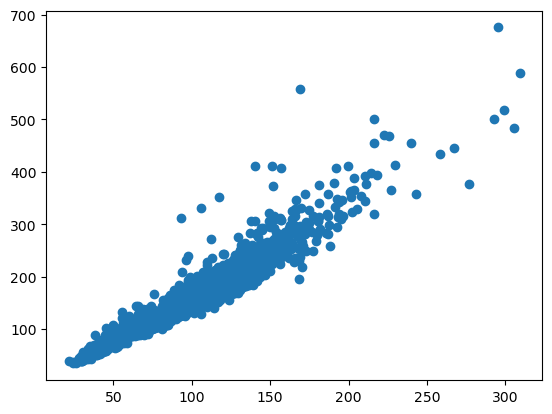

In [9]:
plt.scatter(prcp_rl['10y'],prcp_rl['100y'])

In [11]:
prcp_l48 = prcp_rl[['10y','10y_se','mean','mean_se']].join(stations).loc[lambda df: ~df['state'].isin(['AK','HI'])]

## Interpolate Using Guassian Processes

### Define Grid Variables (for the lower 48)

In [109]:
x_mesh, y_mesh, usa_mask = usa_grid(n_width=500, n_height=400)
x_1d = x_mesh.ravel()
y_1d = y_mesh.ravel()

In [114]:
x_x = prcp_l48['longitude'].values
x_y = prcp_l48['latitude'].values
x_z = prcp_l48['elevation'].values/1000 #elevation in km

y = prcp_l48['10y'].astype('float')
y_var = np.power(prcp_l48['10y_se'].astype('float').values,2.0)
X2 = np.array([x_x,x_y]).T
X3 = np.array([x_x,x_y,x_z]).T

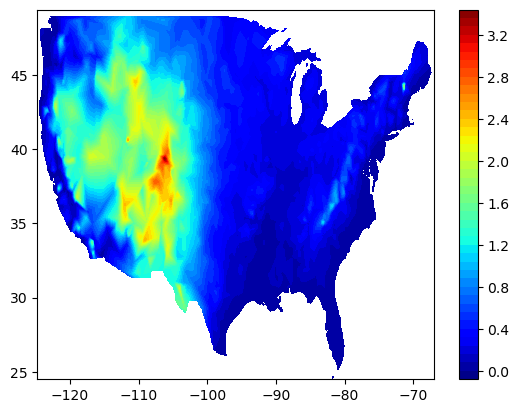

In [119]:
x_z_pred = griddata(X2, x_z, (x_mesh, y_mesh), method='linear')
x_z_pred[~usa_mask.reshape(x_mesh.shape)]=np.nan
plt.contourf(x_mesh,y_mesh,x_z_pred,cmap='jet',levels=50)
plt.colorbar()

In [141]:


# kernel = 1.0 * RBF(length_scale=(1e0,1e0,1e1), length_scale_bounds=(1e-3, 1e4))
# kernel += WhiteKernel( noise_level=1e-4, noise_level_bounds=(1e-8, 1e-1))
# gpr_prcp = GaussianProcessRegressor(kernel=kernel, alpha=y_var,  n_restarts_optimizer=2

kernel = 1.0 * RBF(length_scale=(0.75,1.0), length_scale_bounds='fixed')
gpr_prcp = GaussianProcessRegressor(kernel=kernel, alpha=y_var, normalize_y=True)

gpr_prcp.fit(X2,y)

GaussianProcessRegressor(alpha=array([364.60470861,  54.49613217,  43.67260174, ...,  20.17197197,
        58.77334761,  26.98720471]),
                         kernel=1**2 * RBF(length_scale=[0.75, 1]),
                         normalize_y=True)

In [142]:
print('fit', gpr_prcp.kernel_)

fit 0.683**2 * RBF(length_scale=[0.75, 1])


In [144]:
X_pred = np.array([x_1d,y_1d]).T
y_pred, y_pred_z = gpr_prcp.predict(X_pred, return_std=True)

y_pred_mesh = y_pred.reshape(x_mesh.shape).copy()
y_pred_mesh[~usa_mask.reshape(x_mesh.shape)]=np.nan

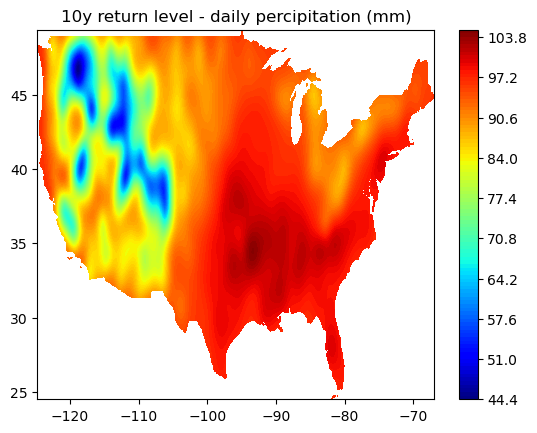

In [145]:
plt.contourf(x_mesh,y_mesh,y_pred_mesh,100,cmap='jet')
plt.colorbar()
plt.title('10y return level - daily percipitation (mm)');